# Compare postprocessing procedures

In this code I compare the post-processing implemented for the cryoscope routine with the code used up to now to perform post-processing of cryoscope reconstruction

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import json
import cma

import scipy
import scipy.signal
from scipy.optimize import least_squares
from scipy.optimize import least_squares, minimize, Bounds
from pathlib import Path

from qibocal.protocols.two_qubit_interaction.cryoscope import CryoscopeResults, CryoscopeData
from qibocal.protocols.ramsey.utils import fitting


from cryoscope_scripts import load_cryoscope_data
from IIR import (
    step,
    inverse_model_IIR,
    residuals_inverse_IIR,
    multi_exponential_IIR,
    residuals_multi_exponential,
    iter_filter_application
)

from tools import plot_reconstructed_data, plot_signal_filtered, plot_signal_filtered_iter, Signal

FLUX_AMPLITUDE = 0.5
DIRECT = False
ITERATIONS = 5
DATA_START = 0

[Qibo 0.2.12|INFO|2025-01-10 10:24:16]: Loading platform dummy
[Qibo 0.2.12|INFO|2025-01-10 10:24:16]: Loading platform dummy


In [2]:
data_path = Path.cwd().parent / "cryo_material" / "long_acquisition" / "data" / "cryoscope-0"
data_json = data_path / "data.json"

with open(data_json, "rb") as file:
    data = json.load(file)

flux_pulse_amplitude = data["\"flux_pulse_amplitude\""]
cryoscope_data = load_cryoscope_data(data_path / "data.npz", FLUX_AMPLITUDE)

In [3]:
def fit_no_postprocessing(data: CryoscopeData) -> CryoscopeResults:
    """Postprocessing for cryoscope experiment.

    From <X> and <Y> we compute the expecting step response.
    The complex data <X> + i <Y> are demodulated using the frequency found
    by fitting a sinusoid to both <X> and <Y>.
    Next, the phase is computed and finally the detuning using a savgol_filter.
    The "real" detuning is computed by reintroducing the demodulation frequency.
    Finally, using the parameters given by the flux_amplitude_frequency experiment,
    we compute the expected flux_amplitude by inverting the formula:

    f = c_1 A^2 + c_2 A + c_3

    where f is the detuning and A is the flux amplitude.
    The step response is computed by normalizing the amplitude by its value computed above.
    For some of the manipulations see: https://github.com/DiCarloLab-Delft/PycQED_py3/blob/c4279cbebd97748dc47127e56f6225021f169257/pycqed/analysis/tools/cryoscope_tools.py#L73
    """

    nyquist_order = 0

    fitted_parameters = {}
    detuning = {}
    amplitude = {}
    step_response = {}
    alpha = {}
    time_decay = {}
    feedforward_taps = {}
    feedback_taps = {}
    for qubit, setup in data.data:
        qubit_data = data[qubit, setup]
        t = qubit_data.duration
        y = 1 - 2 * qubit_data.prob_1

        popt, _ = fitting(t, y)

        fitted_parameters[qubit, setup] = popt

    qubits = np.unique([i[0] for i in data.data]).tolist()

    for qubit in qubits:

        sampling_rate = 1 / (t[1] - t[0])
        X_exp = 1 - 2 * data[(qubit, "MX")].prob_1
        Y_exp = 1 - 2 * data[(qubit, "MY")].prob_1

        norm_data = X_exp + 1j * Y_exp

        # demodulation frequency found by fitting sinusoidal
        demod_freq = -fitted_parameters[qubit, "MY"][2] / 2 / np.pi * sampling_rate

        # to be used in savgol_filter
        derivative_window_length = 7 / sampling_rate
        derivative_window_size = max(3, int(derivative_window_length * sampling_rate))
        derivative_window_size += (derivative_window_size + 1) % 2

        # find demodulatation frequency
        demod_data = np.exp(2 * np.pi * 1j * t * demod_freq) * (norm_data)

        # compute phase
        phase = np.unwrap(np.angle(demod_data))

        # compute detuning
        raw_detuning = (
            scipy.signal.savgol_filter(
                phase / (2 * np.pi),
                window_length=derivative_window_size,
                polyorder=2,
                deriv=1,
            )
            * sampling_rate
        )

        # real detuning (reintroducing demod_freq)
        detuning[qubit] = (
            raw_detuning - demod_freq + sampling_rate * nyquist_order
        ).tolist()

        # params from flux_amplitude_frequency_protocol
        params = [1.9412681243469971, -0.012534948170662627, 0.0005454772278201887]
        # params = [  # D2
        #     2.0578,
        #     -0.065,
        #     0.00147,
        # ]

        # invert frequency amplitude formula
        p = np.poly1d(params)
        amplitude[qubit] = [max((p - freq).roots).real for freq in detuning[qubit]]

        # compute step response
        step_response[qubit] = (
            np.array(amplitude[qubit]) / data.flux_pulse_amplitude
        ).tolist()

        return CryoscopeResults(
            amplitude=amplitude,
            detuning=detuning,
            step_response=step_response,
            fitted_parameters=fitted_parameters,
            A=alpha,
            tau=time_decay,
            fir=feedforward_taps,
            iir=feedback_taps,
        )

In [4]:
cryoscope_results = fit_no_postprocessing(cryoscope_data)

**Test plot function**

In [5]:
t = np.arange(0,99,1)
start = 10

In [6]:
print(t)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98]


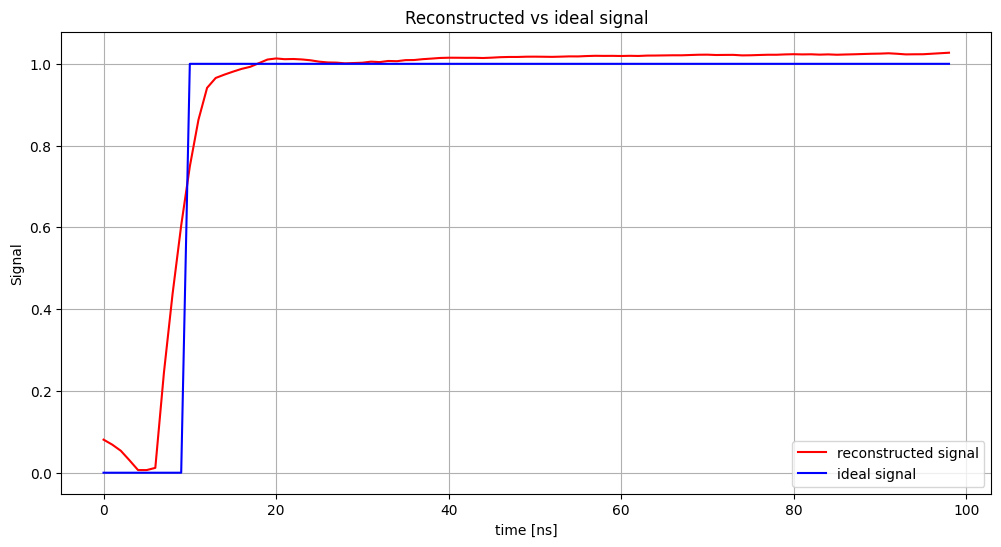

<module 'matplotlib.pyplot' from '/home/elisa/.pyenv/versions/calibration/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [7]:
plot_reconstructed_data(cryoscope_results, "D1", DATA_START, t, start)

### IIR Filters 

In [8]:
#single filter application
initial_guess = [1,1,1]
step_response = cryoscope_results.step_response["D1"]
result = least_squares(residuals_inverse_IIR, initial_guess, args=(t, start, step_response))

with open("single_IIR_step.pkl", "wb") as pickle_file:
    pickle.dump(result, pickle_file)

In [9]:
print(result.x)

[ 1.01281825  0.19478486 -0.26135589]


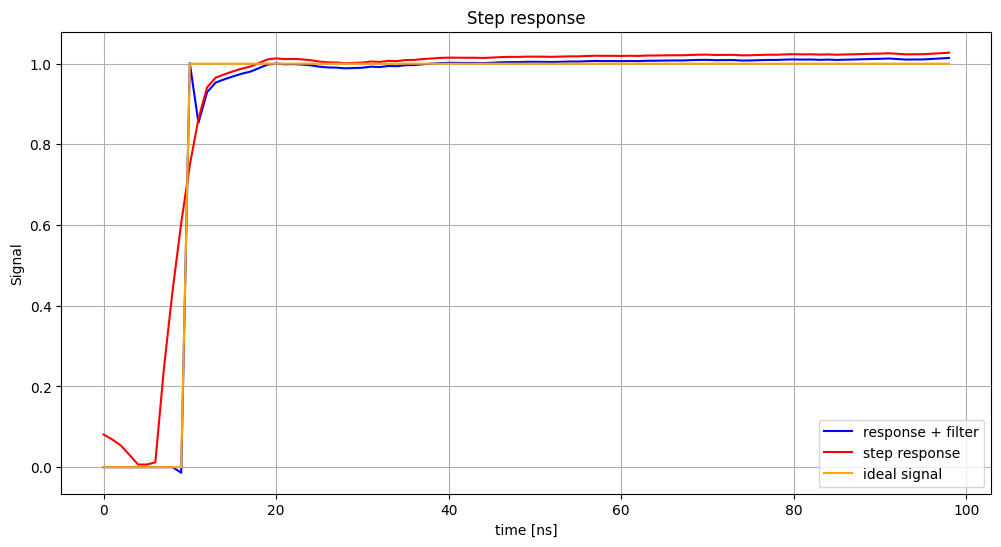

In [10]:
filtered_response = Signal(
    inverse_model_IIR(result.x, t, start, step_response), label="response + filter"
)

response = Signal(step_response, label="step response")

plot_signal_filtered(filtered_response, response, t, start)

## Testing with postprocessing code

In [11]:
FULL_WAVEFORM = np.concatenate([np.zeros(10), np.ones(90)])
START = 10
t = cryoscope_data.data["D1", "MX"].duration
print(t)

def residuals(params, step_response, t):
    duration = len(t)
    g, tau, A = params
    expmodel = step_response / (g * (1 + A * np.exp(-(t - START) / tau)))
    return expmodel - FULL_WAVEFORM[:duration]

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96
 97 98 99]


In [12]:
duration = len(cryoscope_data.data["D1", "MX"].duration)
t = np.arange(0,duration,1)
print(t)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98]


In [13]:
result = least_squares(residuals, initial_guess, args=(step_response, t))


In [14]:
print(result.x)

[ 1.01281825  0.19478486 -0.26135589]
